<a href="https://colab.research.google.com/github/Anshuu96/-Medical-Insurance-Cost-Prediction/blob/main/Medical_Insurance_Cost_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='l1'></a>
# **Importing the Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy as sp
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')


#**Data loading**

In [ ]:
df=pd.read_csv("/content/insurance.csv")

In [ ]:
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [ ]:
df.sample(5)

,age,sex,bmi,children,smoker,region,expenses
1204,18,female,27.3,3,yes,southeast,18223.45
583,32,female,23.7,1,no,southeast,17626.24
1099,25,female,34.0,1,no,southeast,3227.12
731,53,male,21.4,1,no,southwest,10065.41
1305,24,female,27.7,0,no,southeast,2464.62


In [ ]:
df.shape

(1338, 7)

#**EDA**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df.isnull().sum() # no null values

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
expenses,0


In [ ]:
#getting all the statistics of numerical columns
df.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


In [ ]:
df.duplicated().sum()

np.int64(1)

In [ ]:
duplicates=df.duplicated()
df[duplicates]

,age,sex,bmi,children,smoker,region,expenses
581,19,male,30.6,0,no,northwest,1639.56


In [ ]:
#these two rows are duplicate
duplicates_all = df[df.duplicated(keep=False)]
duplicates_all


,age,sex,bmi,children,smoker,region,expenses
195,19,male,30.6,0,no,northwest,1639.56
581,19,male,30.6,0,no,northwest,1639.56


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.nunique()

,0
age,47
sex,2
bmi,275
children,6
smoker,2
region,4
expenses,1337


In [ ]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'expenses'], dtype='object')

In [ ]:
df['age'].dtype

dtype('int64')

In [ ]:
df.head(1)

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92


In [ ]:
#getting the numerical feature and categorical features
num_features = [feature for feature in df.columns if df[feature].dtype!='O']
cat_features = [feature for feature in df.columns if df[feature].dtype=='O']
target = "charges"

print(f'We have {len(num_features)} number of  numerical features which are', num_features)
print(f'We have {len(cat_features)}  number of categorical featureswhich are', cat_features)


We have 4 number of  numerical features which are ['age', 'bmi', 'children', 'expenses']
We have 3  number of categorical featureswhich are ['sex', 'smoker', 'region']


In [ ]:
num_data = df[num_features]
cat_data = df[cat_features]

<Axes: xlabel='bmi_range', ylabel='count'>

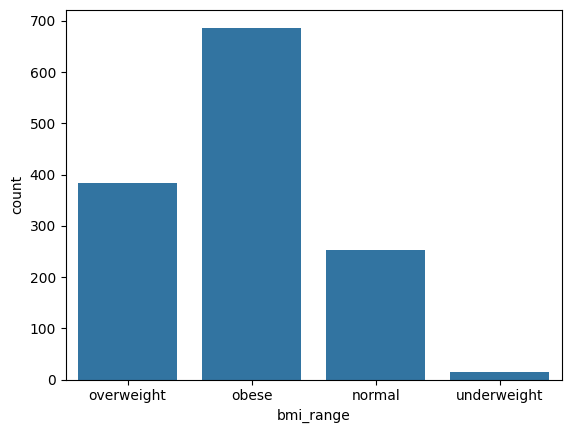

In [ ]:
df['bmi_range'] = 'normal'
df.loc[(df['bmi'] < 18), 'bmi_range'] = 'underweight'
df.loc[(df['bmi'] > 25.0) & (df['bmi'] < 30), 'bmi_range'] = 'overweight'
df.loc[(df['bmi'] > 30.1), 'bmi_range'] = 'obese'
df.head()
sns.countplot(x=df['bmi_range'])

In [ ]:
df.value_counts(['sex','smoker'])

sex     smoker
female  no        547
male    no        516
        yes       159
female  yes       115
Name: count, dtype: int64

In [ ]:
#pivot table for sex and smoker
pd.crosstab(df['sex'],df['smoker'])

smoker,no,yes
sex,,
female,547,115
male,516,159


We can see female smokers are less than male smokers

In [ ]:
df.value_counts(['sex','bmi_range'])

sex     bmi_range  
male    obese          361
female  obese          326
        overweight     197
male    overweight     187
female  normal         132
male    normal         120
female  underweight      7
male    underweight      7
Name: count, dtype: int64

In [ ]:
num_data.corr()

,age,bmi,children,expenses
age,1.000000,0.109414,0.041536,0.298308
bmi,0.109414,1.000000,0.012641,0.198637
children,0.041536,0.012641,1.000000,0.067389
expenses,0.298308,0.198637,0.067389,1.000000


##**EDA for univariate**


<Axes: xlabel='sex', ylabel='count'>

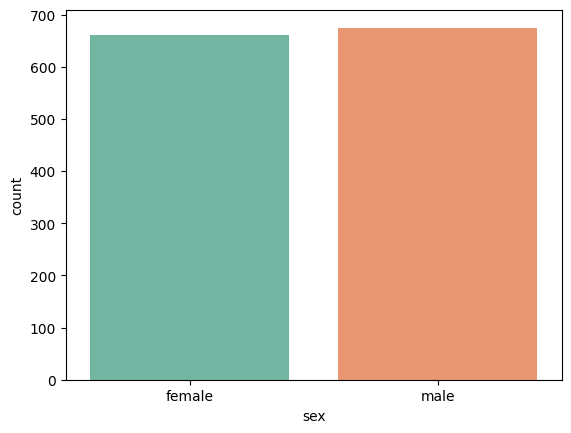

In [ ]:
sns.countplot(x='sex',data=df,palette='Set2')


<Axes: xlabel='smoker', ylabel='count'>

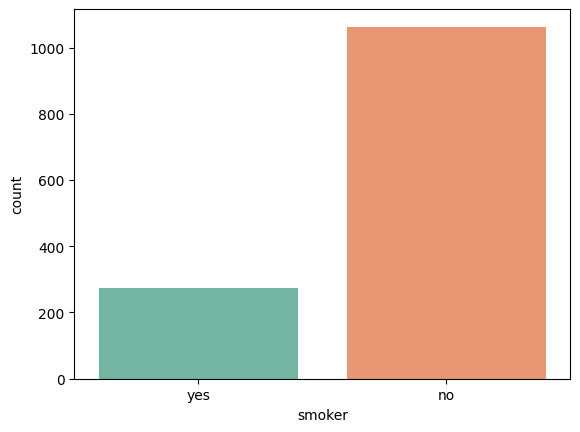

In [ ]:
sns.countplot(x='smoker', data=df,palette='Set2')

<Axes: xlabel='bmi_range', ylabel='count'>

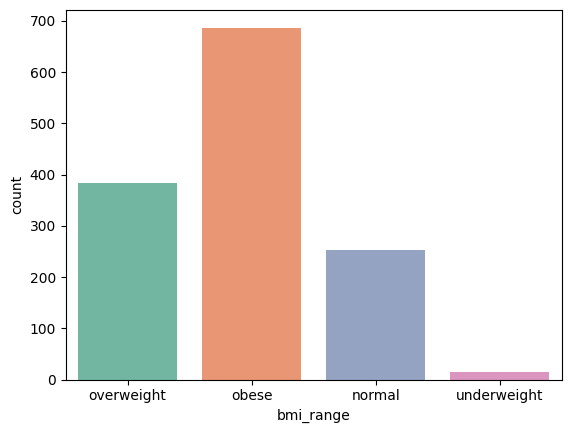

In [ ]:
sns.countplot(x='bmi_range', data=df,palette='Set2')

No. of people who are overweight and obese are more

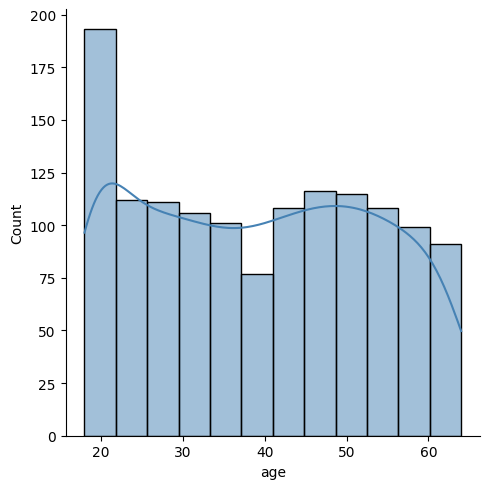

In [ ]:
sns.displot(df['age'], color= ('steelblue'), kde=True)

we can see age is not normally distributed

<Axes: ylabel='age'>

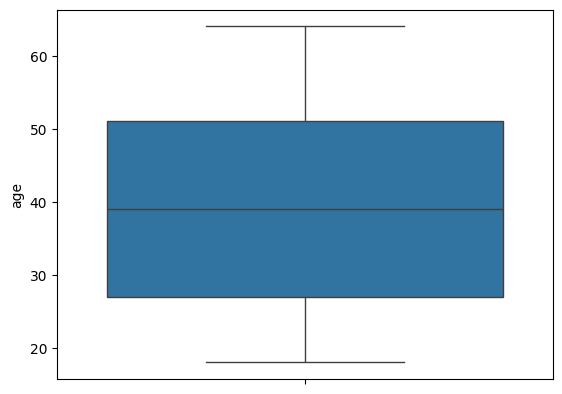

In [ ]:
sns.boxplot(df['age'])

<Axes: xlabel='bmi', ylabel='Density'>

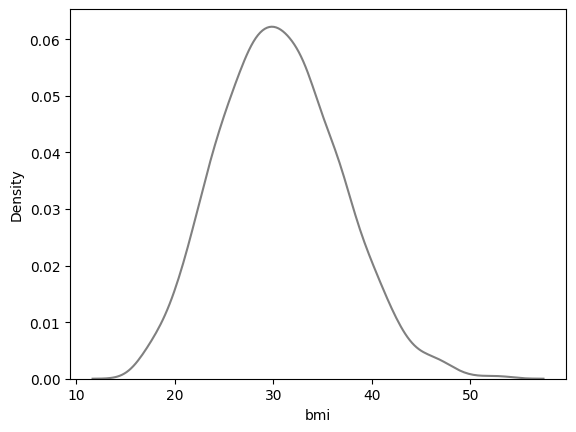

In [ ]:
sns.distplot(df['bmi'], color= ('grey'), kde=True,hist=False)

`bmi` is approximately Normally distributed

<Axes: ylabel='bmi'>

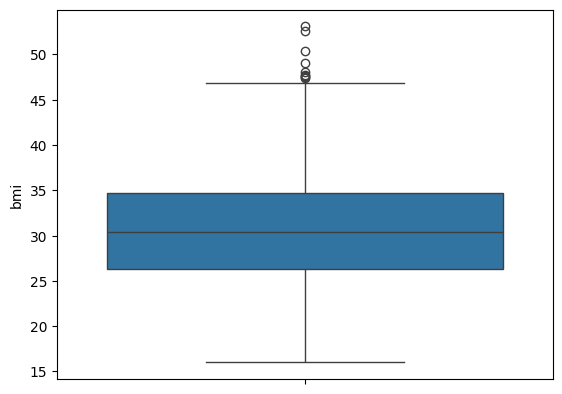

In [ ]:
sns.boxplot(df['bmi'])

outliers are present in `bmi` features at the upper tail region


In [ ]:
df['bmi'].skew()

np.float64(0.28446275054239506)

`bmi` is slightly right skewed

In [ ]:
print("Mean value of bmi",df['bmi'].mean())
print("Std value of bmi",df['bmi'].std())
print("Min value of bmi",df['bmi'].min())
print("Max value of bmi",df['bmi'].max())

Mean value of bmi 30.665519820493646
Std value of bmi 6.100663828592314
Min value of bmi 16.0
Max value of bmi 53.1


In [ ]:
# Finding the boundary values
print("Highest allowed",df['bmi'].mean() + 3*df['bmi'].std())
print("Lowest allowed",df['bmi'].mean() - 3*df['bmi'].std())

Highest allowed 48.96751130627059
Lowest allowed 12.363528334716705


In [ ]:
#finding the z value to remove outliers
df['bmi_zscore'] = (df['bmi'] - df['bmi'].mean())/df['bmi'].std()

In [ ]:
df.shape

(1337, 9)

In [ ]:
# Trimming
new_df = df[(df['bmi_zscore'] < 3) & (df['bmi_zscore'] > -3)]
new_df.shape

(1333, 9)

<Axes: ylabel='bmi'>

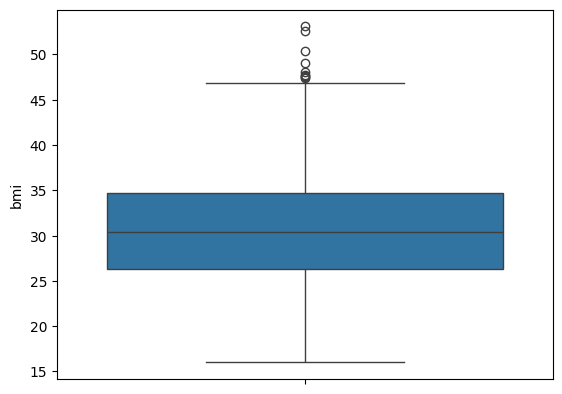

In [ ]:
sns.boxplot(df['bmi'])

some outliers are still there it might be because the bmi data was skewed

In [ ]:
#removing outliers
Q1 = df['bmi'].quantile(0.25)
Q3 = df['bmi'].quantile(0.75)
IQR = Q3-Q1

lb = Q1 - 1.5*IQR
ub = Q3 + 1.5*IQR

df = df[(df['bmi'] >= lb) & (df['bmi'] <= ub)]
df.shape

(1328, 9)

<Axes: ylabel='bmi'>

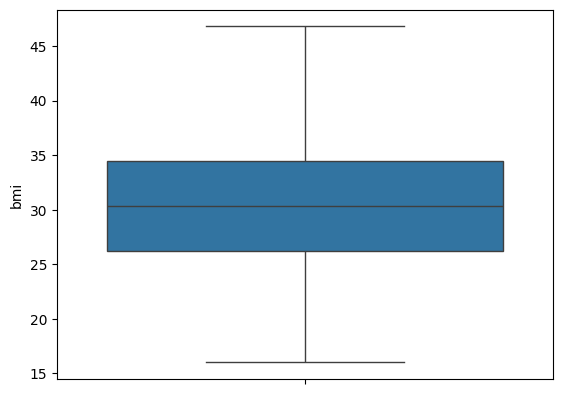

In [ ]:
sns.boxplot(df['bmi'])

Now no outlers are present in bmi dataset

##Observing the target column graph

<Axes: xlabel='expenses', ylabel='Density'>

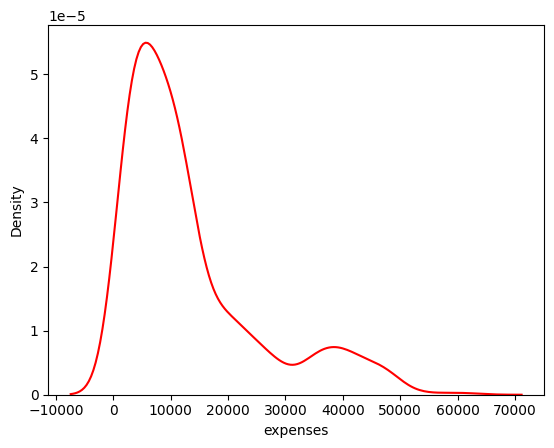

In [ ]:
sns.distplot(df['expenses'], color= ('red'), kde=True,hist=False)

we can see the `Expenses` column is not normally distributed

##**Bivariate Analysis**

<Axes: xlabel='sex', ylabel='expenses'>

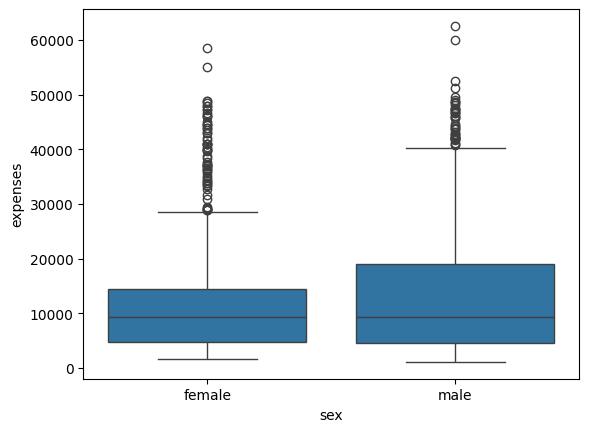

In [ ]:
sns.boxplot(df, x='sex', y = 'expenses')

<Axes: xlabel='children', ylabel='expenses'>

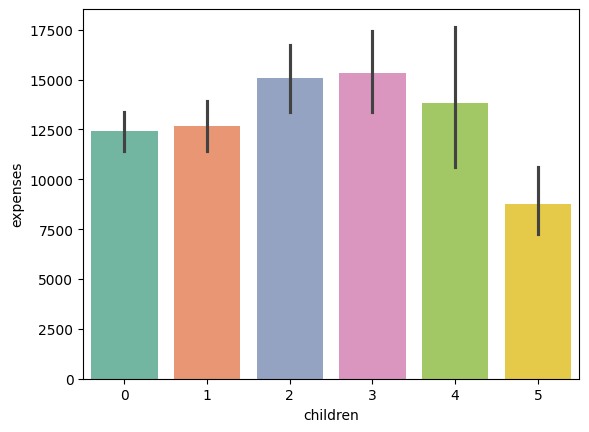

In [ ]:
sns.barplot(new_df, x = 'children', y = 'expenses',palette='Set2')

Families with more than 2 children have to pay higher prices of medical insurance. Surprisingly, families with 5 children pay lower insurance costs which can be due to financial instability and poor educational awareness.

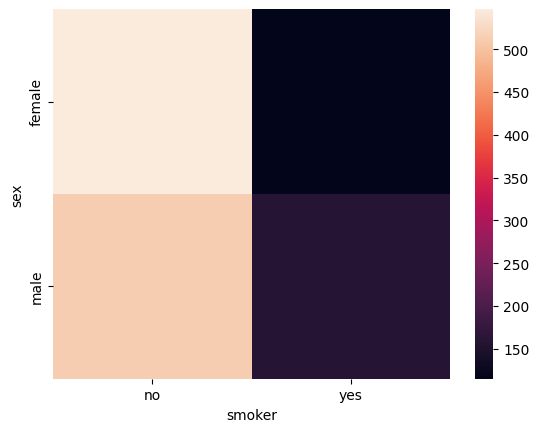

In [ ]:
sns.heatmap(pd.crosstab(new_df['sex'],new_df['smoker']))
plt.show()

<Axes: xlabel='smoker', ylabel='expenses'>

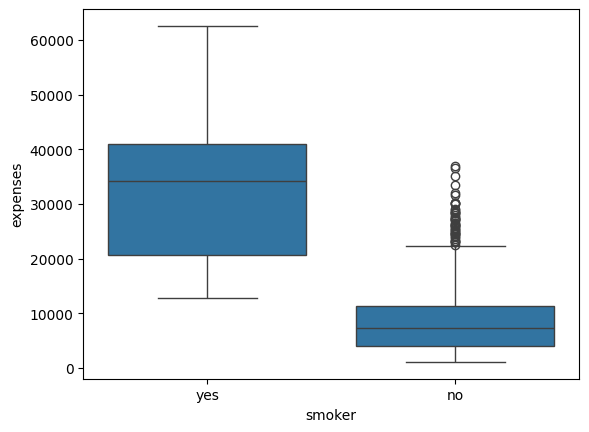

In [ ]:
sns.boxplot(df, x='smoker', y = 'expenses')

There exist some individuals who do not smoke but have comparitively higher insurance prices than majority of non-smokers.

In [ ]:
pd.crosstab(df['bmi_range'],df['smoker'])

smoker,no,yes
bmi_range,,
normal,198,54
obese,538,140
overweight,310,74
underweight,11,3


In [ ]:
 #observing normal obese overweight according to smoking havint and age
new_df.loc[(new_df['age'] > 45), 'overage'] = 'yes'
new_df.loc[(new_df['age'] <= 45), 'overage'] = 'no'
pd.crosstab(index=[new_df['overage'], new_df['smoker']], columns=new_df['bmi_range'],values=new_df['expenses'],aggfunc='mean' )

bmi_range             normal         obese    overweight  underweight
overage smoker                                                       
no      no       5806.167704   5846.241242   5797.392886      3510.95
        yes     18831.797000  39243.883111  20498.932500     20006.43
yes     no      12303.504286  12831.940638  12753.518532          NaN
        yes     23808.621429  46038.579423  26182.535385          NaN

There are two conclusion from the above pivot table \
`1` Expenses are high if they are smokers. \
`2` If they are overaged then there expenses will be also high

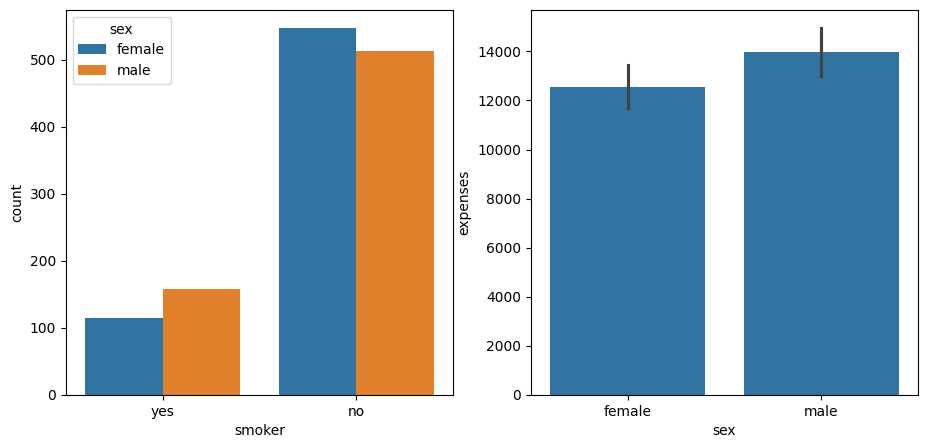

In [ ]:

fig, ax = plt.subplots(1,2,figsize=(11,5))

sns.countplot(data=new_df, x=new_df['smoker'], hue=new_df['sex'], ax=ax[0])
sns.barplot(new_df, x = 'sex', y = 'expenses', ax = ax[1])
fig.show()

A higher proportion of the smokers are males and it can be observed that males pay higher prices of medical insurance

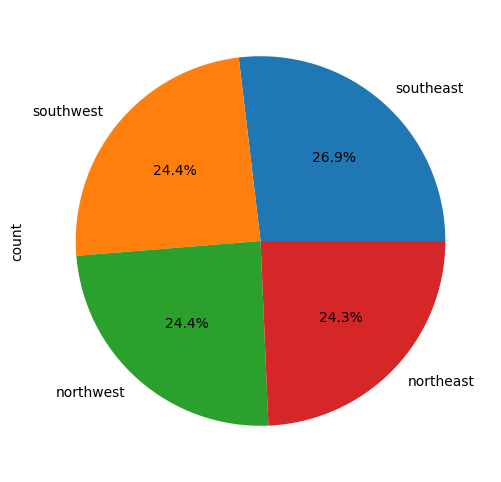

In [ ]:
df['region'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6,6))
plt.show()


The whole data is evenly distributed over the population

expenses    1.000000
age         0.298308
bmi         0.198637
children    0.067389
Name: expenses, dtype: float64 



<Axes: >

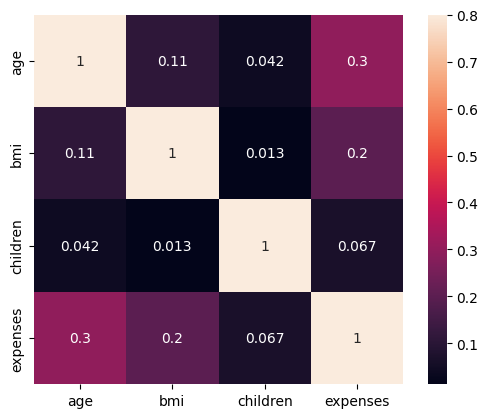

In [ ]:
correlation = num_data.corr()
print(correlation['expenses'].sort_values(ascending=False),'\n')
sns.heatmap(correlation, square=True, vmax=0.8, annot=True)

There does not exist any high correlation between any of the columns


<Axes: xlabel='region', ylabel='expenses'>

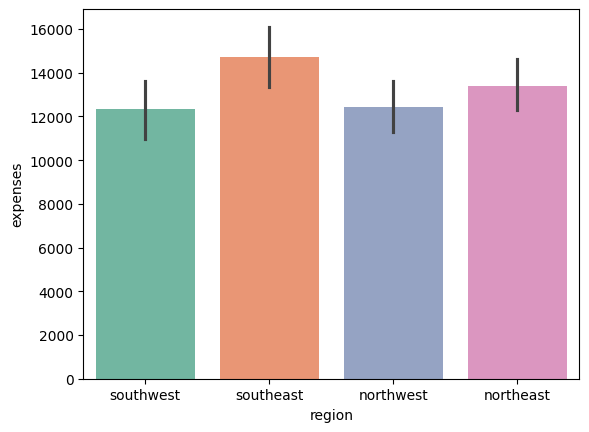

In [ ]:
#making barplot for expenses and region
sns.barplot(new_df, x = 'region', y = 'expenses',palette='Set2')

we can see southeast people pay a bit more than other region

In [ ]:
new_df.head() # we have dropped the added columns which were bmi_range and bmi_zscore

,age,sex,bmi,children,smoker,region,expenses,bmi_range,bmi_zscore,overage
0,19,female,27.9,0,yes,southwest,16884.92,overweight,-0.453315,no
1,18,male,33.8,1,no,southeast,1725.55,obese,0.513793,no
2,28,male,33.0,3,no,southeast,4449.46,obese,0.382660,no
3,33,male,22.7,0,no,northwest,21984.47,normal,-1.305681,no
4,32,male,28.9,0,no,northwest,3866.86,overweight,-0.289398,no


#**PreProcessing**

##**One Hot Encoding**

In [ ]:
#one hot encoding
cat_data = pd.get_dummies(cat_data, drop_first=True,dtype=np.int32)
cat_data.head()

,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0,1,0,0,1
1,1,0,0,1,0
2,1,0,0,1,0
3,1,0,1,0,0
4,1,0,1,0,0


In [ ]:
#adding above dataframe with num_data
df = pd.concat([num_data, cat_data], axis=1)
df.head()


,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.9,0,16884.92,0,1,0,0,1
1,18,33.8,1,1725.55,1,0,0,1,0
2,28,33.0,3,4449.46,1,0,0,1,0
3,33,22.7,0,21984.47,1,0,1,0,0
4,32,28.9,0,3866.86,1,0,1,0,0


##**Scaling**

In [ ]:
X = df.drop('expenses', axis=1)
y = df['expenses']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#scaling
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
X_train_scaled = pd.DataFrame(X_train, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test, columns=X.columns)

In [ ]:
X_train_scaled.shape[1]

8

In [ ]:
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()


In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               expenses   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.0
Date:                Fri, 03 Oct 2025   Prob (F-statistic):               0.00
Time:                        07:04:17   Log-Likelihood:                -13538.
No. Observations:                1337   AIC:                         2.709e+04
Df Residuals:                    1328   BIC:                         2.714e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04    988.219    -12.082      0.000   -1.39e+04      -1e+04
age                256.7472     11.912     21.554      0.000     233.379     280.116
bmi                339.3472     28.610     11.861      0.000     283.221     395.473
children           475.0071    137.892      3.445      0.001     204.496     745.518
sex_male          -129.5144    333.185     -0.389      0.698    -783.140     524.111
smoker_yes        2.385e+04    413.334     57.693      0.000     2.3e+04    2.47e+04
region_northwest  -349.0429    476.809     -0.732      0.464   -1284.424     586.338
region_southeast -1035.8409    478.855     -2.163      0.031   -1975.236     -96.445
region_southwest  -959.3365    478.085     -2.007      0.045   -1897.220     -21.453
==============================================================================
Omnibus:                      299.949   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              717.046
Skew:                           1.211   Prob(JB):                    1.97e-156
Kurtosis:                       5.647   Cond. No.                         311.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##**INFLUENTIAL POINTS**

In [ ]:
influence = model.get_influence()
cooks = influence.cooks_distance
print(cooks)

(array([2.03461470e-03, 5.05434475e-05, 9.78389275e-05, ...,
       1.28217008e-04, 1.08425111e-05, 1.91730530e-03]), array([1., 1., 1., ..., 1., 1., 1.]))


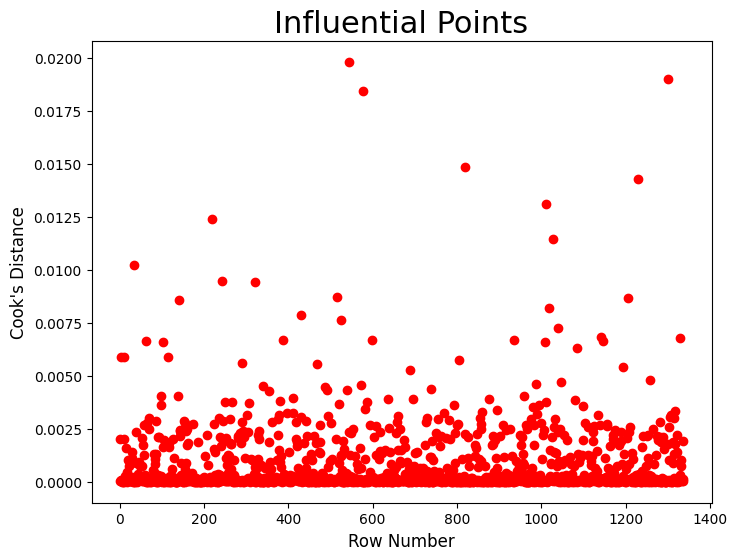

In [ ]:
plt.figure(figsize = (8,6))
plt.scatter(df.index, cooks[0], color='red')
plt.xlabel('Row Number', fontsize=12)
plt.ylabel("Cook's Distance", fontsize=12)
plt.title("Influential Points", fontsize=22)
plt.show()


In [ ]:
mean_cooks = np.mean(cooks[0])
mean_cooks

np.float64(0.0008419517504815391)

In [ ]:
influential_points = df.index[cooks[0] > (4/1338)]
influential_points

Index([   3,    9,   34,   62,   98,   99,  102,  115,  138,  140,  219,  235,
        242,  250,  266,  289,  301,  306,  321,  340,  355,  379,  380,  387,
        397,  411,  412,  429,  430,  468,  488,  491,  494,  516,  520,  526,
        539,  543,  573,  577,  583,  587,  599,  637,  661,  688,  696,  730,
        739,  770,  793,  806,  819,  854,  860,  876,  896,  936,  959,  980,
        987,  989,  994, 1008, 1011, 1012, 1019, 1027, 1039, 1047, 1080, 1085,
       1100, 1134, 1142, 1146, 1195, 1206, 1230, 1258, 1300, 1306, 1307, 1314,
       1317, 1328],
      dtype='int64')

In [ ]:
df.iloc[influential_points, :]

,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
3,33,22.7,0,21984.47,1,0,1,0,0
9,60,25.8,0,28923.14,0,0,1,0,0
34,28,36.4,1,51194.56,1,1,0,0,1
62,64,24.7,1,30166.62,1,0,1,0,0
98,56,20.0,0,22412.65,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...
1307,32,28.1,4,21472.48,1,1,1,0,0
1308,25,30.2,0,33900.65,0,1,0,0,1
1315,18,28.3,1,11272.33,1,0,0,0,0
1318,35,39.7,4,19496.72,1,0,0,0,0


In [ ]:
df = df.drop(influential_points)
df.head()

,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.9,0,16884.92,0,1,0,0,1
1,18,33.8,1,1725.55,1,0,0,1,0
2,28,33.0,3,4449.46,1,0,0,1,0
4,32,28.9,0,3866.86,1,0,1,0,0
5,31,25.7,0,3756.62,0,0,0,1,0


#**Fitting the MLR Model**

In [ ]:
X = df.drop(columns = 'expenses', axis=1)
Y = df['expenses']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Again we will perform the scaling

In [ ]:
#scaling
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
X_train_scaled = pd.DataFrame(X_train, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test, columns=X.columns)

In [ ]:
X_train_scaled.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0.022635,1.720993,-0.069307,0.990050,-0.481173,-0.560411,-0.597371,-0.594289
1,-0.691399,2.037717,0.755776,-1.010051,-0.481173,-0.560411,1.674002,-0.594289
2,-1.548239,0.404089,-0.894389,0.990050,-0.481173,-0.560411,1.674002,-0.594289
3,0.522458,2.771182,-0.069307,0.990050,-0.481173,-0.560411,1.674002,-0.594289
4,1.093685,0.720813,-0.069307,0.990050,-0.481173,-0.560411,-0.597371,-0.594289


In [ ]:
lr = LinearRegression()
model = lr.fit(X_train, Y_train)

In [ ]:
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

In [ ]:
print(model.intercept_)

12374.355019999999


In [ ]:
print("Training R^2 = ",r2_score(Y_train, Y_train_pred))
print("Testing R^2 = ",r2_score(Y_test, Y_test_pred))

Training R^2 =  0.8496520330979158
Testing R^2 =  0.8380581288698353


As we can see before the r2 score was around 0.75 after removing the **Influential point** the r2 score increased upto 0.84

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X = df.drop('expenses', axis=1)
y = df['expenses']

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# OLS model
import statsmodels.api as sm
X_with_const = sm.add_constant(X_train_scaled)
ols_model = sm.OLS(y_train, X_with_const).fit()
ols_coefs = pd.Series(ols_model.params.values, index=ols_model.params.index)


##1. **Linearity**

#**Assumption**

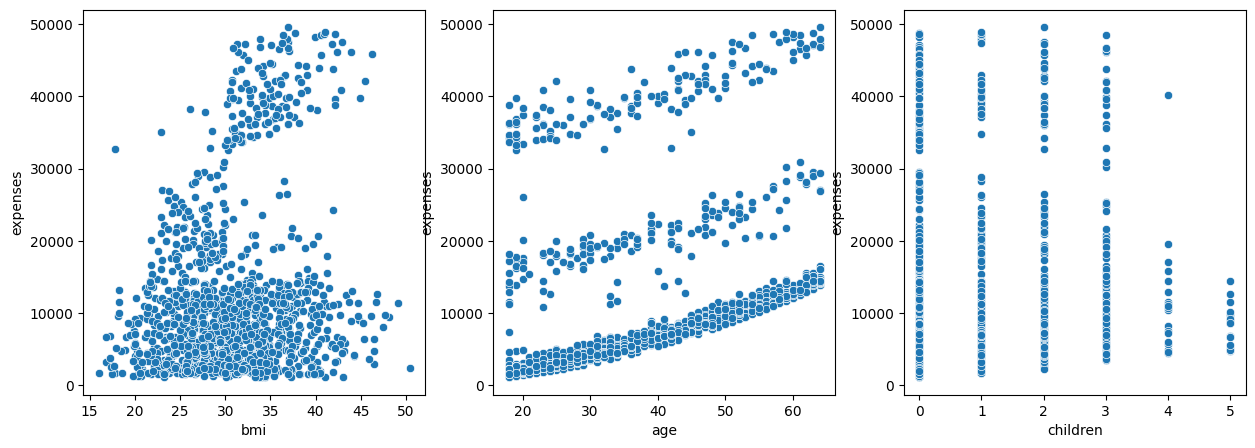

In [ ]:
 #to draw a subplot for bmi,age, children with expenses

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
sns.scatterplot(x=df['bmi'], y=df['expenses'],ax=ax1)
sns.scatterplot(x=df['age'], y=df['expenses'],ax=ax2)
sns.scatterplot(x=df['children'], y=df['expenses'],ax=ax3)
plt.show()


linearity exist somewhat

2. **Normality Of residuals**

In [ ]:
residual=Y_test-Y_test_pred

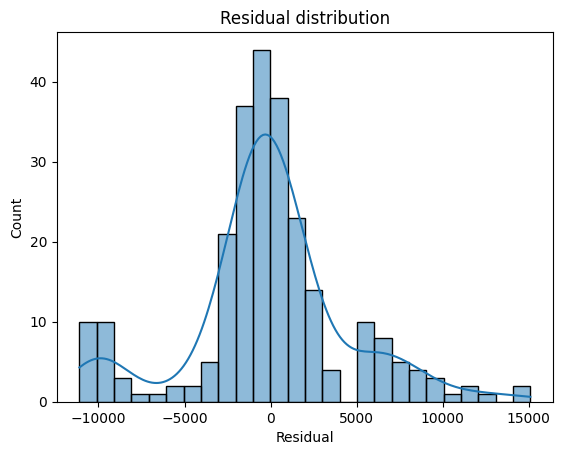

In [ ]:
sns.histplot(residual, kde=True)
plt.xlabel("Residual")
plt.title("Residual distribution")
plt.show()

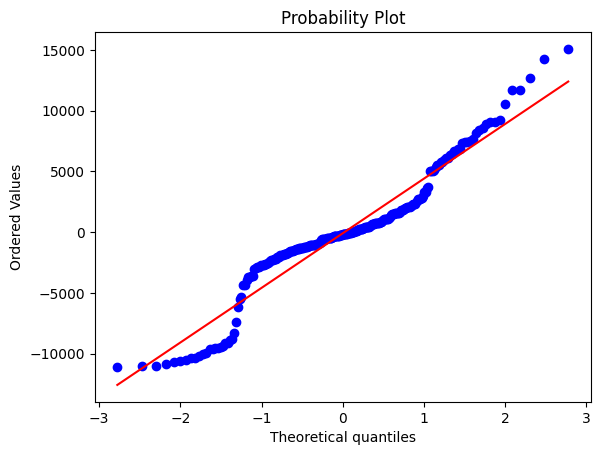

In [ ]:
#QQ plot
stats.probplot(residual, dist="norm", plot=plt)
plt.show()

In [ ]:
#shapiro-wilk test
statistic, p_value = sp.stats.shapiro(residual)
print("Statistic :", statistic)
print("p value :", p_value)

Statistic : 0.9284795295966688
p value : 1.1731423732140007e-09


Since p value < 0.05, Ho is rejected, indicating residuals are not normally distributed

3.**Homoscedasticity**

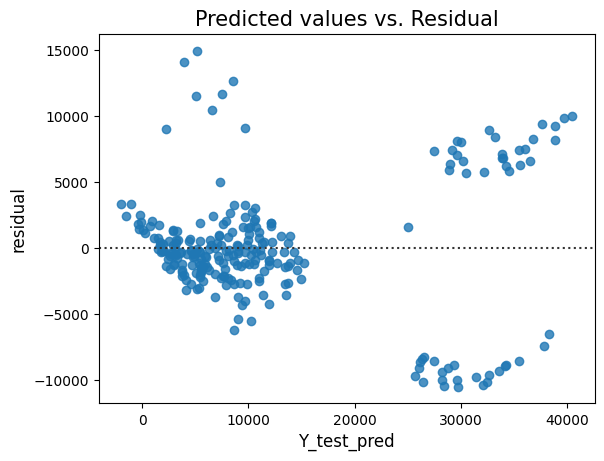

In [ ]:
sns.residplot(x=Y_test_pred, y=residual)
plt.xlabel("Y_test_pred", fontsize = 12)
plt.ylabel("residual", fontsize = 12)
plt.title("Predicted values vs. Residual", fontsize=15)
plt.show()

As from the above figure we can that we cant find any pattern of data between the `residuals` and `Y_test_pred` , therefore it is homoscedastic

4. **Multicollinearity**

In [ ]:
#VIF
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,7.852067,age
1,11.684033,bmi
2,1.796142,children
3,2.022784,sex_male
4,1.250616,smoker_yes
5,1.883230,region_northwest
6,2.287826,region_southeast
7,1.977523,region_southwest


VIF of 'age' feature is greater than 5 indicating possible existence of multicollinearity.
VIF of 'bmi' feature is greater that 10 indicating presence of significant multicollinearity that needs to be corrected.

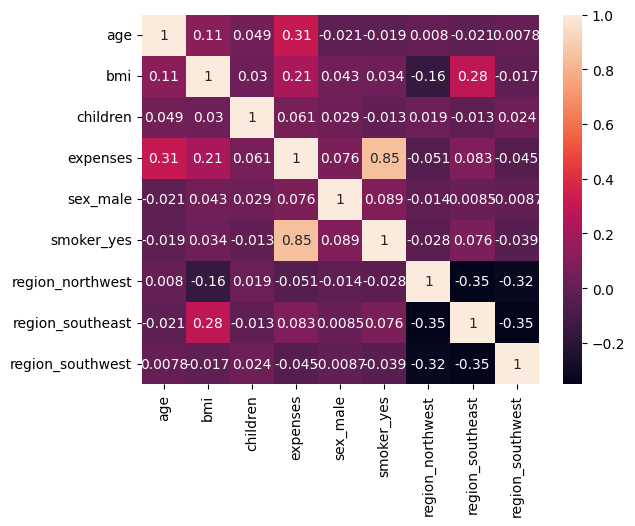

In [ ]:
# CORRELATION HEATMAP
sns.heatmap(df.corr(), annot=True)
plt.show()

But after drawing the heatmap we can see there does not exist high collinearity between any two columns of the data therefore multicollinearity also does not exist

In [ ]:
4630#standard deviation of residual
np.std(residual)

4630.307880099525

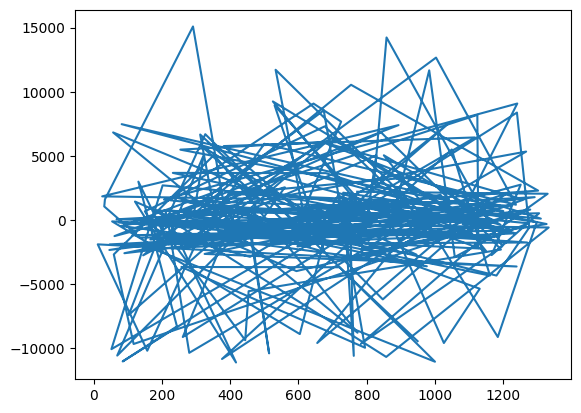

In [ ]:
plt.plot(residual)

From the plot also we can say that there is no Autocorrelation

#**Applying all other models**

In [ ]:
def evaluate_model(true, predicted, n, p):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, predicted)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return mae, mse, r2, rmse, adjusted_r2

In [ ]:
models = {

    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Decision Tree": DecisionTreeRegressor(),
}
model_list = []
r2_list = []
adjusted_r2_list = []
cv_scores = []

for i in range(len(list(models))):
    model = list(models.values())[i]

    # Training
    model.fit(X_train, Y_train)

    # Predictions
    Y_train_pred= model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # Evaluations
    n_train, p_train = X_train.shape
    n_test, p_test = X_test.shape

    model_train_mae, model_train_mse, model_train_r2, model_train_rmse, model_train_adj_r2 = evaluate_model(Y_train, Y_train_pred, n_train, p_train)
    model_test_mae, model_test_mse, model_test_r2, model_test_rmse, model_test_adj_r2 = evaluate_model(Y_test, Y_test_pred, n_test, p_test)

    # Cross-validation score
    cv_score = cross_val_score(model, X, Y, cv=5, scoring='r2').mean()
    cv_scores.append(cv_score)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))
    print("- Adjusted R2 Score: {:.4f}".format(model_train_adj_r2))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    print("- Adjusted R2 Score: {:.4f}".format(model_test_adj_r2))
    print("- Cross-validation Score: {:.4f}".format(cv_score))

    r2_list.append(model_test_r2)
    adjusted_r2_list.append(model_test_adj_r2)
    cv_scores.append(cv_score)

    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 4459.4269
- Mean Absolute Error: 3048.2363
- R2 Score: 0.8497
- Adjusted R2 Score: 0.8484
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4631.2042
- Mean Absolute Error: 3124.0818
- R2 Score: 0.8381
- Adjusted R2 Score: 0.8327
- Cross-validation Score: 0.8448


Ridge
Model performance for Training set
- Root Mean Squared Error: 4459.8936
- Mean Absolute Error: 3056.9828
- R2 Score: 0.8496
- Adjusted R2 Score: 0.8484
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4624.3680
- Mean Absolute Error: 3130.4807
- R2 Score: 0.8385
- Adjusted R2 Score: 0.8332
- Cross-validation Score: 0.8447


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 279.5358
- Mean Absolute Error: 12.5012
- R2 Score: 0.9994
- Adjusted R2 Score: 0.9994
----------------------------------
Model performance for Test set
- Root 

In [ ]:
pd.DataFrame(
    list(zip(model_list, r2_list, adjusted_r2_list)),
    columns=['Model Name', 'R2 Score', 'Adjusted R2']
).sort_values(by=['R2 Score'], ascending=False)

,Model Name,R2 Score,Adjusted R2
2,Decision Tree,0.892891,0.889350
1,Ridge,0.838536,0.833198
0,Linear Regression,0.838058,0.832705
